# Факторы риска для здоровья беременных

<font size = 4> **Описание проекта**
    
Риски для здоровья беременных пациенток могут быть связаны с различными состояниями здоровья, такими как кровяное давление, возраст, частота сердечных сокращений и т.д. Влияние осложнений беременности на материнские и неонатальные исходы оценить трудно, поскольку осложнения беременности состоят из широкого спектра состояний с различной степенью тяжести.   
По разным оценкам, ежегодно во всем мире регистрируется 358 000 случаев материнской смертности, причем около 99% случаев приходится на бедные развивающиеся страны.       
Ожидается, что ранний скрининг снизит показатели материнской смертности.  
В наличии есть данные, которые были собраны из различных больниц, общественных клиник, служб охраны материнского здоровья с помощью системы мониторинга рисков, основанной на системе IoT (Интернет вещей).

<font size = 4> **Цель проекта**

* Нам нужно провести, анализ факторов риска, которые могут вызвать осложнения состояния здоровья у матери.  
* Построить модель машинного обучения прогнозирующую риск здоровья у беременных на основе имеющихся данных.

<font size = 4> **План проекта**

**1.  Изучение данных.**  
  
1.1 Установим библиотеки.  
1.2 Выполним импорт нужных библиотек и методов работы с данными.  
1.3 Считываем данные из `CSV-файла` в датафрейм и сохраняем в переменную.  
1.4 Выводим основную информацию о датафрейме методами `info` и `describe`.  

    
**2.  Предобработка данных.**  
    
2.1  Выполним поиск и обработку дубликатов.   
2.2  Выполним поиск и обработку аномальных значений.   
2.3  Создадим новые признаки для прогнозирования оттока клиентов. 
2.4  Переведём целевой признак RiskLevel в числовой тип. 
     
    
**3.  Исследовательский анализ данных.**  
    
3.1  Рассчитаем корреляцию Пирсона в данных.   
3.2  Рассчитаем Phik корреляцию для признаков.    
3.3  Рассмотрим баланс классов целевого признака `customer_leave`.   
3.4  Выполним поиск зависимостей между признаками.    
    
    
**4.  Подготовка данных для работы моделей машинного обучения.**  
    
4.1  Выделим целевой признак и признаки на основе которых будем строить модель машинного обучения.    
4.2  Разделим данные на тренировочную и тестовую выборки.     
4.3  Выполним кодирование и масштабирование признаков.    

    
**5.  Построение и анализ моделей машинного обучения.**    
    
5.1  Исследуем модель логистической регрессии `LogisticRegression`.      
5.2  Исследуем модель случайного леса `RandomForestClassifier`.    
5.3  Исследуем модель `LightGBMClassifier`.   
5.4  Исследуем ансамблирование модели методом `VotingClassifier`.   
    
    
**6.  Проверка "лучшей" модели.**   
    
6.1  Проверим качество итоговой модели на тестовой выборке.    
6.2  Построим кривые обучения модели.    
6.3  Проверим модель на адекватность.    
6.4  Оценим важность признаков для работы модели.      
    
    
**7.  Итоговый вывод.**    

## Изучение данных

### Установим библиотеки.

In [ ]:
pip install phik

In [ ]:
pip install lightgbm

In [ ]:
pip install optuna

### Выполним импорт нужных библиотек и методов работы с данными.

In [1]:
# Импорт стандартных библиотек
import warnings
import time

# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import optuna

# Отключение предупреждений
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# Импорт моделей машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier

# Импорт метрик
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             roc_curve,
                             auc,
                             ConfusionMatrixDisplay,
                             classification_report)

# Импорт способов создания цепочек автоматических действий (выполняются одна за другой)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Импорт способов преобразований признаков
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)

# Импорт способов работы с выборками и построения кривых обучения
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_val_predict,
                                     learning_curve, 
                                     LearningCurveDisplay)

# Импорт метода исследования важности признаков
from sklearn.inspection import permutation_importance

# Объявление константы для воспроизводимости псевдослучайных значений 
RANDOM_STATE = 23

### Считываем данные из CSV-файла в датафрейм и сохраняем в переменную.

In [3]:
df = pd.read_csv('d:\Data_science\Projects_jupiter\data\kaggle\Maternal_health_risk\Maternal Health Risk Data Set.csv')

In [4]:
# Вывод случайных строк таблицы
df.sample(5)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
59,15,76,49,6.4,98.0,77,low risk
620,17,85,60,7.5,101.0,86,high risk
202,23,90,60,7.5,98.0,76,low risk
726,17,85,60,9.0,102.0,86,mid risk
133,54,140,100,15.0,98.0,66,high risk


**Описание данных** 

`Age` —  Возраст в годах (когда женщина беременна).  
`SystolicBP` —  Верхнее значение артериального давления в мм рт.ст. (еще один важный признак во время беременности).   
`DiastolicBP` —  Нижнее значение артериального давления в мм рт.ст. (еще один важный признак во время беременности).     
`BS` — Уровень глюкозы в крови выражается в молярной концентрации, ммоль/л.    
`BodyTemp` — Температура тела в F.   
`HeartRate` — Нормальная частота сердечных сокращений в состоянии покоя в ударах в минуту.    
`RiskLevel` —  Прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего признака.   

### Выводим основную информацию о датафрейме методами `info` и `describe`.

In [5]:
# Вывод основной информации о данных методом "info"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [6]:
# Вывод основной информации о данных методом "describe"
df.describe(include='all')

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014
unique,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,low risk
freq,NaN,NaN,NaN,NaN,NaN,NaN,406
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775,NaN
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702,NaN
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,NaN
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,NaN
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,NaN
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,NaN


**Замечание:**  Данных довольно мало. Признаки имеют численные и категориальные значения. Пропуски в данных отсутствуют. 

## Предобработка данных

### Выполним поиск и обработку дубликатов.

In [7]:
# Подсчёт количества явных дубликатов
df.duplicated().sum()

562

In [8]:
# Удаление дубликатов
df_drop = df.drop_duplicates(keep='first').reset_index(drop=True)
df_drop

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
447,12,100,50,6.4,98.0,70,mid risk
448,15,100,60,6.0,98.0,80,low risk
449,15,100,49,7.6,98.0,77,low risk
450,12,100,50,6.0,98.0,70,mid risk


**Замечание:** После удаления дубликатов осталось меньше половины данных.

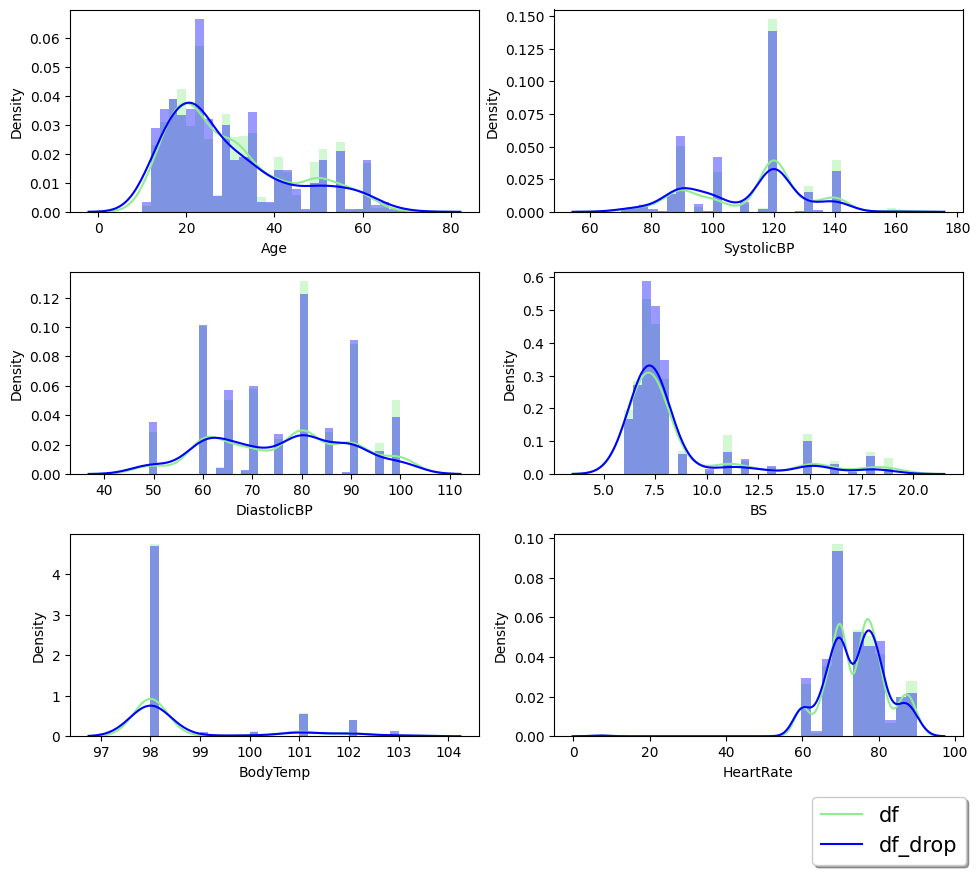

In [9]:
# Построение гистограмм плотности распределения признаков до и после удаления дубликатов
fig = plt.figure(figsize=(10, 8));
count = 1 
for column in df.columns[:-1]:
    plt.subplot(3, 2, count)
    sns.distplot(df[column], color='lightgreen', label='df', bins=30)
    sns.distplot(df_drop[column], color='blue', label='df_drop', bins=30)
    count += 1
plt.tight_layout()
fig.legend(labels=['df', 'df_drop'],
           bbox_to_anchor=(0.99, 0.01),
           fontsize=15,
           shadow=True,
           framealpha=1)
plt.show()

**Замечание:** После удаления дубликатов распределения признаков изменились незначительно. Их удаление не должно повлиять на качество наших прогнозов. Для работы линейных моделей удаление дубликатов напротив может улучшить качество работы.

### Выполним поиск и обработку аномальных значений.
Рассмотрим возраст беременных и частоту сердечных сокращений. 
Судя по гистограммам распределения остальные показатели здоровья человека имеют вполне реальные значения.

#### Рассмотрим возраст беременных.

In [10]:
df_drop[(df_drop['Age'] < 12) | (df_drop['Age'] > 60)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
19,10,70,50,6.9,98.0,70,low risk
109,63,140,90,15.0,98.0,90,high risk
175,10,85,65,6.9,98.0,70,low risk
228,62,120,80,6.9,98.0,66,low risk
236,65,90,60,6.9,98.0,70,low risk
240,66,85,60,6.9,98.0,86,low risk
246,70,85,60,6.9,102.0,70,low risk
247,65,120,90,6.9,103.0,76,low risk
304,65,130,80,15.0,98.0,86,high risk
444,10,100,50,6.0,99.0,70,mid risk


**Замечание:** Заметим, что в данных присутствуют данные для женщин возрастом старше 60 и меньше 12 лет. Что довольно странно, при том что в большинстве случаев уровень риска - низкий. Однако такая ситуация возможна впринципе, поэтому оставим их. 

#### Рассмотрим частоту сердечных сокращений.

In [11]:
df_drop[(df_drop['HeartRate'] < 60)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
342,16,120,75,7.9,98.0,7,low risk


**Замечание:** У нас присутствует одно значение равное 7, что является аномалией. Скорее всего это просто ошибка заполнения, поэтому заменим значение 7 на 70.

In [12]:
df_drop.loc[df_drop['HeartRate'] == 7, 'HeartRate'] = 70
df_drop.iloc[342]

Age                  16
SystolicBP          120
DiastolicBP          75
BS                  7.9
BodyTemp           98.0
HeartRate            70
RiskLevel      low risk
Name: 342, dtype: object

### Создадим новые признаки для прогнозирования оттока клиентов.
Для улучшения прогноза будущей модели добавим в таблицу информацию о категориях к которым принадлежит тот или иной признак.

#### Разделим беременных женщин на возрастные группы.

* `children` - младше 15 лет   
* `young` - от 15 до 24 лет  
* `adult` - от 25 до 39 лет  
* `senior` - старше 40 лет   

In [13]:
# Разделение возрастов женщин на категории
sections = [(df_drop['Age'] <= 14 ),\
            ((df_drop['Age'] > 14) & (df_drop['Age'] <= 24)),\
            ((df_drop['Age'] > 24) & (df_drop['Age'] <= 39)),\
            (df_drop['Age'] > 39)]
choice =['children', 'young', 'adult', 'senior']
df_drop['Age_group'] = np.select(sections, choice)

#### Выделим группы женщин по систалическому артериальному давлению по данным клиники Майо. 

* `normal` - верхнее значение АД ниже 120 и нижнее значение АД ниже 80    
* `elevated` - верхнее значение АД от 120 до 129 и нижнее значение АД ниже 80   
* `stage_1` - верхнее значение АД от 130 до 139 или нижнее значение АД от 80 до 89   
* `stage_2` - верхнее значение АД выше 140 или нижнее значение АД выше 89    

In [14]:
# Разделение на группы по систолическому артериальному давлению (клиника Майо)
sections = [((df_drop['SystolicBP'] < 120 ) & (df_drop['DiastolicBP'] < 80)),\
            ((df_drop['SystolicBP'] >= 120) & (df_drop['SystolicBP'] <= 129) &
             (df_drop['DiastolicBP'] < 80)),\
            ((df_drop['SystolicBP'] >= 130) & (df_drop['SystolicBP'] <= 139) |
             (df_drop['DiastolicBP'] >= 80) & (df_drop['DiastolicBP'] <= 89)),\
            ((df_drop['SystolicBP'] >= 140) | (df_drop['DiastolicBP'] > 89))]
choice =['normal', 'elevated', 'stage_1', 'stage_2']
df_drop['Systolic_group'] = np.select(sections,choice)

#### Выделим группы женщин по уровню сахара в крови по данным клиники Майо. 

* `normal` - уровень сахара 8 или ниже    
* `prediabetes` - уровень сахара выше 8, но ниже 11    
* `diabetes` - уровень сахара выше 11     

In [15]:
# Разделение на категории по уровню сахара в крови (клиника Майо)
sections = [(df_drop['BS'] <= 8),\
            ((df_drop['BS'] > 8) & (df_drop['BS'] <= 11)),\
            (df_drop['BS'] > 11)]
choice =['normal','prediabetes','diabetes']
df_drop['BS_group'] = np.select(sections,choice)

#### Выделим группы женщин по температуре тела. 

* `low` - температура ниже 97,7    
* `normal` - температура от 97,7 до 99,5   
* `high` - температура выше 99,5    

In [16]:
# Разделение на категории по температуре тела человека
sections = [(df_drop['BodyTemp'] < 97.7),\
            ((df_drop['BodyTemp'] >= 97.7) & (df_drop['BodyTemp'] <= 99.5)),\
            (df_drop['BodyTemp'] > 99.5)]
choice =['low','normal','high']
df_drop['BodyTemp_group'] = np.select(sections,choice)

In [17]:
# Вывод случайных строк таблицы
df_drop.sample(5)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Age_group,Systolic_group,BS_group,BodyTemp_group
30,20,100,90,7.10,98.0,88,low risk,young,stage_2,normal,normal
251,12,95,60,6.90,98.0,77,low risk,children,normal,normal,normal
15,15,120,80,7.01,98.0,70,low risk,young,stage_1,normal,normal
440,15,90,49,6.00,98.0,77,low risk,young,normal,normal,normal
377,50,130,100,16.00,98.0,75,mid risk,senior,stage_1,diabetes,normal


**Замечание:** В итоге мы добавили 4 категориальных признака.

###  Переведём целевой признак `RiskLevel` в числовой тип.

* `0` - low risk
* `1` - mid risk
* `2` - high risk

In [18]:
# Копирование данных
df_drop_num = df_drop.copy()

# Замена значений целевого признака
df_drop_num['RiskLevel'] = df_drop_num['RiskLevel'].replace('low risk', 0)
df_drop_num['RiskLevel'] = df_drop_num['RiskLevel'].replace('mid risk', 1)
df_drop_num['RiskLevel'] = df_drop_num['RiskLevel'].replace('high risk', 2)

## Исследовательский анализ данных

### Рассчитаем корреляцию Пирсона в данных.
Данный показатель отражает линейную связь между признаками. Он рассчитывается для числовых признаков.

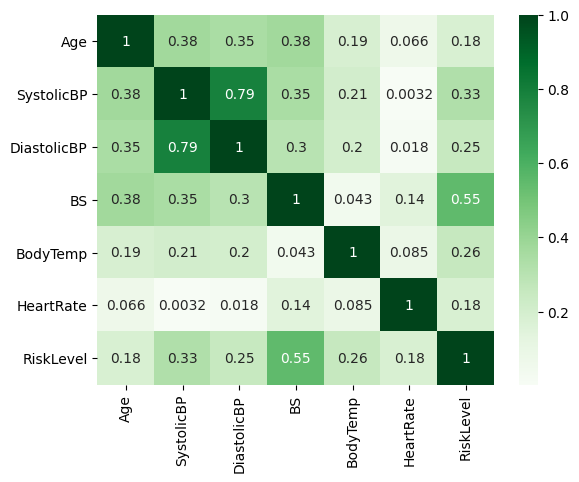

In [19]:
# Вывод значений (по модулю) корреляции Пирсона
sns.heatmap(df_drop_num.corr().abs(), annot=True, cmap='Greens');

**Замечание:** Целевой признак сильнее всего коррелирует с уровнем глюкозы в крови.  
Также можно заметить сильную корреляцию верхего и нижнего значения артериального давления, что очень логично.

### Рассчитаем Phik корреляцию для признаков.
С помощью этого показателя можно отразить нелинейные связи между признаками.

interval columns not set, guessing: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']


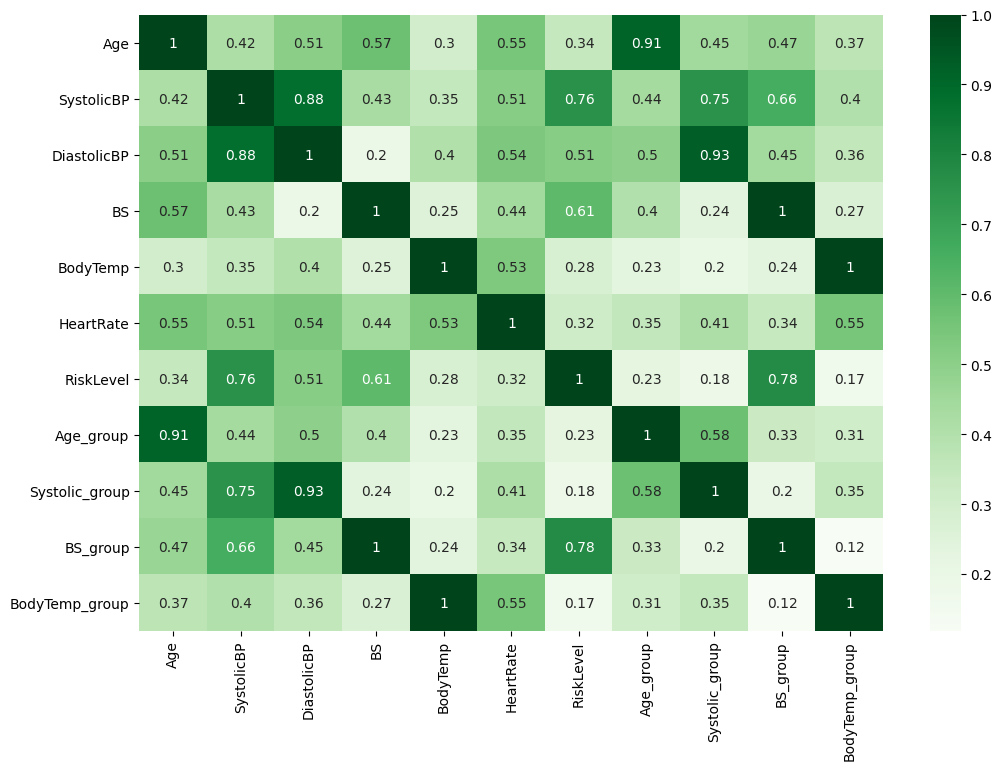

In [20]:
# Вывод значений (по модулю) корреляции Phik
plt.figure(figsize=(12, 8))
sns.heatmap(df_drop.phik_matrix().abs(), annot=True, cmap='Greens');

**Замечание:** Значения корреляции Phik в большинстве выше чем корреляция Пирсона. Можно предположить, что в данных преобладают не линейные взаимосвязи.  
Целевой признак сильнее всего коррелирует с уровнем глюкозы и верхним значение АД женщины. При этом категориальный признак уровня глюкозы имеет большую корреляцию с целевым признаком.  
Новые категориальные признаки ожидаемо сильно коррелируют с исходными признаками.

### Рассмотрим баланс классов целевого признака `customer_leave`.

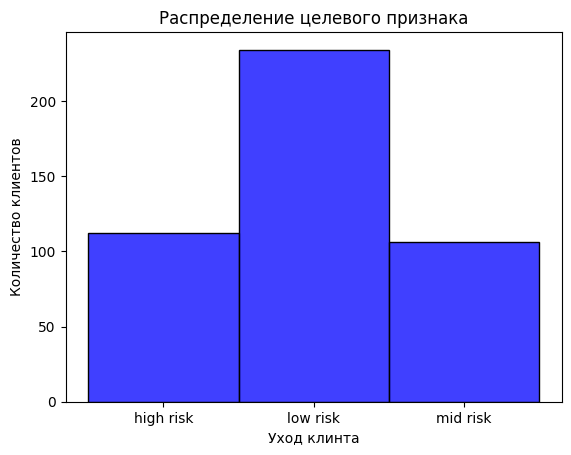

,Доля клиентов,Количество клиентов
low risk,0.517699,234
high risk,0.247788,112
mid risk,0.234513,106


In [21]:
# Построение гистограммы распределения признака
sns.histplot(df_drop['RiskLevel'].astype(str), color='blue')
plt.title('Распределение целевого признака')
plt.xlabel('Уход клинта')
plt.ylabel('Количество клиентов');
plt.show()

# Вывод значений в виде таблицы
pd.DataFrame({'Доля клиентов': df_drop['RiskLevel'].value_counts(normalize=True),
              'Количество клиентов' : df_drop['RiskLevel'].value_counts()})

**Замечание:** Наблюдается явный дисбаланс классов. В наших данных преобладает доля с низким уровнем риска (50 %).

### Выполним поиск зависимостей между признаками.
Рассмотрим наиболее выраженные связи между признаками..

#### Рассмотрим связи числовых признаков.

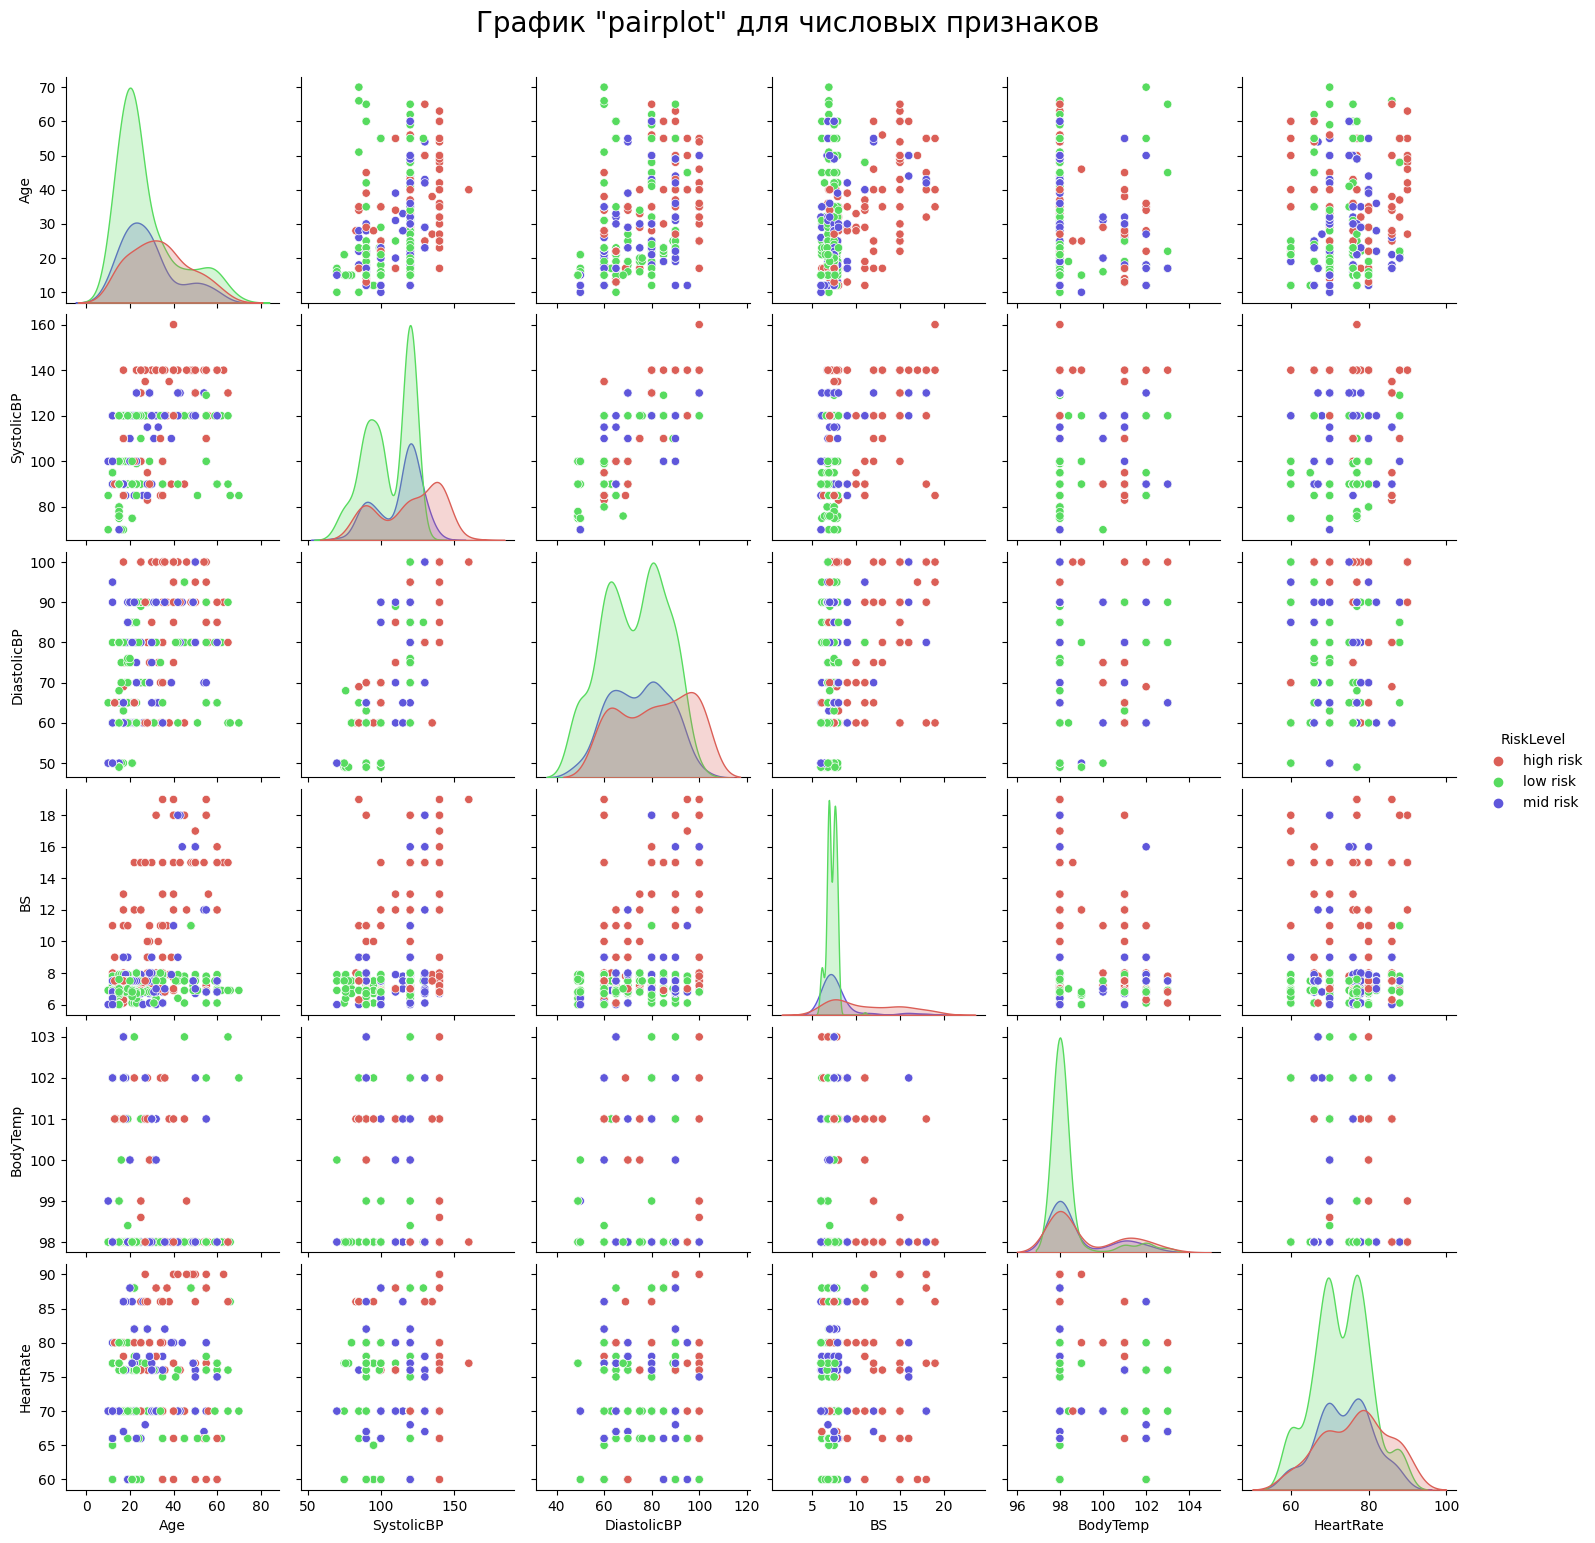

In [22]:
# Построение графика pairplot 
g = sns.pairplot(df_drop, hue='RiskLevel', palette='hls');
g.fig.suptitle('График "pairplot" для числовых признаков', y=1.03, fontsize=20);

**Замечание:** По распределениям можно сказать, что часть признаков имеют связь с высоким риском для здоровья женщин.   
Например, рассмотрим зависимость возраста и уровня глюкозы в крови человека. На графике не видно сильной взаимосвязи между признаками, но при этом заметно, что повышенный уровень сахара (`BS` > 6) повышает и риск здоровья беременных. 

#### Рассмотрим связь признаков `Age_group` и `RiskLevel`.

In [23]:
# Функция для вывода кросстаблицы признаков и столбчатой диаграммы по этой таблице
def crosstab_bar(col1, col2):
    pd.crosstab(col1, col2, normalize='index').plot(kind='bar')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title=col2.name)
    plt.ylabel('Доля женщин');
    plt.title(f'Взаимосвязь признаков {col1.name} и {col2.name}');
    display(pd.crosstab(col1, col2, normalize='index'))

RiskLevel,high risk,low risk,mid risk
Age_group,,,
adult,0.353846,0.361538,0.284615
children,0.233333,0.466667,0.300000
senior,0.378641,0.427184,0.194175
young,0.105820,0.682540,0.211640


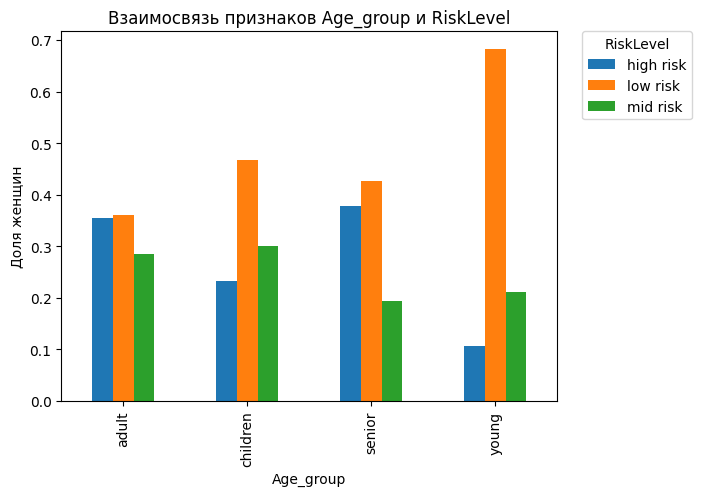

In [24]:
crosstab_bar(df_drop['Age_group'], df_drop['RiskLevel'])

**Замечание:** Очевидно, что уровень риска для здоровья в "молодых" группах ниже.

#### Рассмотрим связь признаков `Systolic_group` и `RiskLevel`.

RiskLevel,high risk,low risk,mid risk
Systolic_group,,,
elevated,0.172414,0.586207,0.241379
normal,0.195531,0.608939,0.195531
stage_1,0.185185,0.503704,0.311111
stage_2,0.431193,0.366972,0.201835


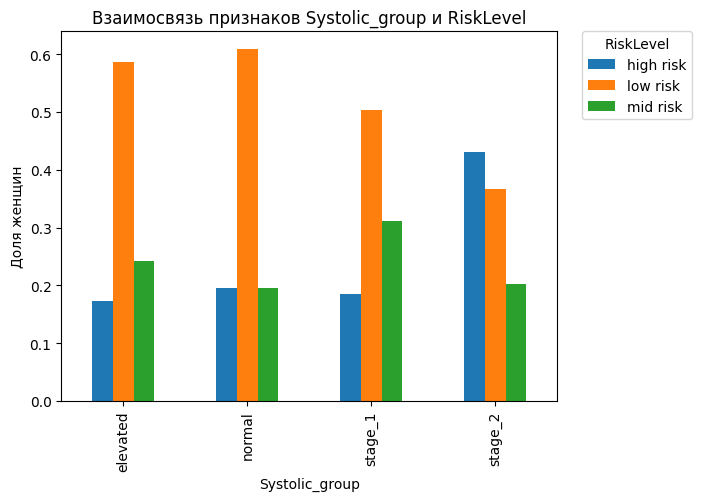

In [25]:
crosstab_bar(df_drop['Systolic_group'], df_drop['RiskLevel'])

**Замечание:** Для женщин в группе `stage_2` высокий уровкень риска.

#### Рассмотрим связь признаков `BS_group` и `RiskLevel`.

RiskLevel,high risk,low risk,mid risk
BS_group,,,
diabetes,0.854545,0.000000,0.145455
normal,0.124661,0.631436,0.243902
prediabetes,0.678571,0.035714,0.285714


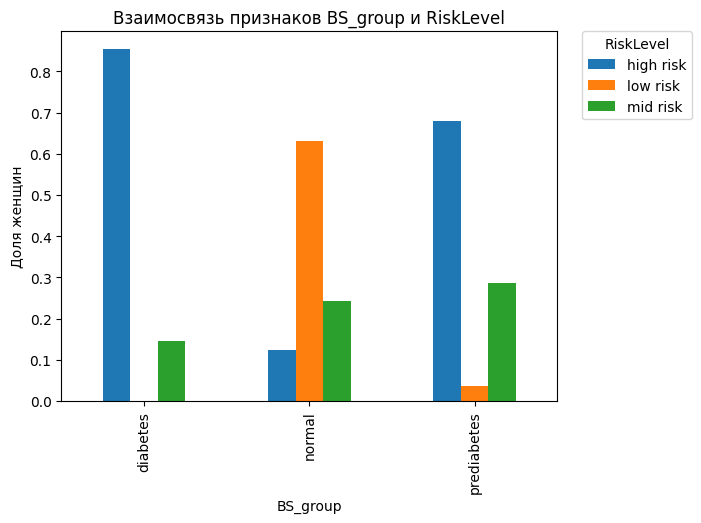

In [26]:
crosstab_bar(df_drop['BS_group'], df_drop['RiskLevel'])

**Замечание:** График подтверждает, что нормальный уровень глюкозы очень важен для здоровья человека. 

#### Рассмотрим связь признаков `BodyTemp_group` и `RiskLevel`.

RiskLevel,high risk,low risk,mid risk
BodyTemp_group,,,
high,0.443182,0.238636,0.318182
normal,0.200549,0.585165,0.214286


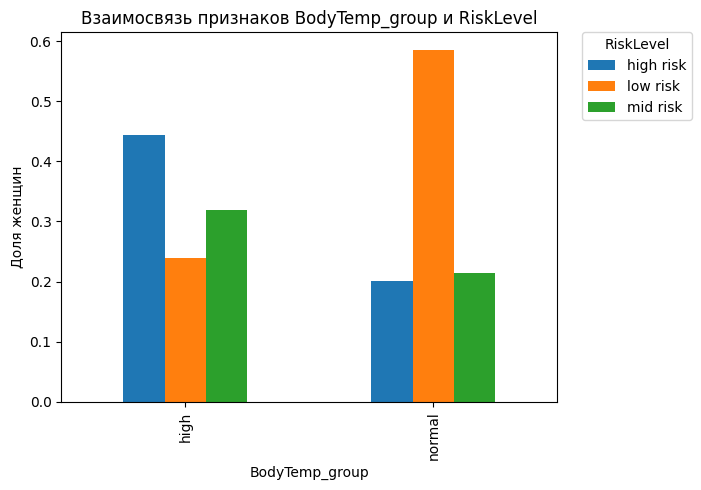

In [27]:
crosstab_bar(df_drop['BodyTemp_group'], df_drop['RiskLevel'])

**Замечание:** Заметим, что у нас нет данных с пониженной температурой человека из группы `low` (температура нижу 97,7 по Фаренгейту). Повышенная температура, ожидаемо, отрицательно влияет на здоровье беременной женщины.

**Вывод:**  
Мы нашли некоторые зависимости признаков. Однако, нужно помнить, что влияние различных факторов на целевую переменную -  это гипотеза. В идеале нужно использовать методы проверки гипотез. В данном проекте мы пропустим это действие.

## Подготовка данных для работы моделей машинного обучения

### Выделим целевой признак и признаки на основе которых будем строить модель машинного обучения.
Работать будем с таблицей `df_drop_num`, так как в ней целевой признак `RiskLevel` уже приведён к числовому типу.

In [28]:
# Создание переменных для целевого признака и для остальных признаков
target = df_drop_num['RiskLevel']
features = df_drop_num.drop(['RiskLevel'], axis=1)
print(target.shape)
print(features.shape)

(452,)
(452, 10)


### Разделим данные на тренировочную и тестовую выборки.

In [29]:
# Разбиение данных на 2 выборки: тренировочную и тестовую в соотношении 75:25
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)
print(f'Размер таблицы признаков тренировочной выборки: {features_train.shape}')
print(f'Размер таблицы целевого признака тренировочной выборки:{target_train.shape}')
print(f'Размер таблицы признаков тестовой выборки: {features_test.shape}')
print(f'Размер таблицы целевого признака тестовой выборки: {target_test.shape}')

Размер таблицы признаков тренировочной выборки: (339, 10)
Размер таблицы целевого признака тренировочной выборки:(339,)
Размер таблицы признаков тестовой выборки: (113, 10)
Размер таблицы целевого признака тестовой выборки: (113,)


### Выполним кодирование  и масштабирование признаков.

Для категориальных признаков выполним приямое кодирование (OHE).   
Для кодирования будем использовать `OneHotEncoder` из `sklearn`. 
Для того чтобы не угодить в дамми-ловушку и не создать проблеммы мультиколлинеарности удалим для каждого признака по одному (первому) столбцу из полученных новых (параметр `drop='first'`).   
Если в тестовых данных появится новое категориальное значение, то кодировщик не создаст дополнительного признака. Если ситуация получится обратная, то в тестовой выборке во всех значениях такого признака будут стоять нули.

Для числовых признаков выполним масштабирование.
Для работы линейных моделей масштабирование может сыграть положительную роль.  
Для "деревянных" моделей масштабирование можно не проводить.  
Для масштабирования будем спользовать `StandardScaler` из `sklearn`. 

Преобразования будем выполнять используя `Pipeline` и `ColumnTransformer`. С их помощью мы решим проблему утечки данных при проведении кросс - валидации. На каждой итерации (обучение - предсказание) мы будем прогонять всю предобработку (кодирование и масштабирование признаков).
После предобработки добавим в итоговый пайплайн модель машинного обучения. Для удобства работы напишем функцию.

In [30]:
# Сохраниние названий категориальных и численных признаков в списки
cat_cols = [x for x in features_train.columns if features_train[x].dtype == 'object']
num_cols = [x for x in features_train.columns if features_train[x].dtype != 'object']
print('Категориальные признаки:', cat_cols)
print('Числовые признаки:', num_cols)

Категориальные признаки: ['Age_group', 'Systolic_group', 'BS_group', 'BodyTemp_group']
Числовые признаки: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']


In [31]:
# Функция построения итогового "пайплайна" с моделью
def final_pipeline(model):
    '''
    model - модель машинного обучения
    '''
    # Построение "пайплайна" для масштабирования числовых признаков
    num_pipeline = Pipeline(steps=[('scale', StandardScaler())])
    
    # Построение "пайплайна" для кодирования категориальных признаков
    cat_pipeline = Pipeline(steps=[('one-hot', OneHotEncoder(drop='first',
                                                             sparse=False,
                                                             handle_unknown='ignore'))])
    
    # Объединение "пайплайнов" в один с помощью "трансформера"
    col_trans = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, num_cols),
                                                ('cat_pipeline', cat_pipeline, cat_cols)],
                                  remainder='drop',
                                  n_jobs=-1)
    
    # Построение итогового "пайплайна" (добавление модели машинного обучения)
    pipeline = Pipeline(steps=[('col_trans', col_trans),
                               ('model', model)])
    return pipeline

## Построение и анализ моделей машинного обучения
В данном разделе проекта мы будем обучать различные модели с перебором гиперпараметров.   

Подбор гиперпараметров моделей будем проводить с помощью модуля `Optuna`.    
Проверять качество моделей будем с помощью кросс - валидации.  
Балансировку классов будем проводить встроенными методами моделей машинного обучения.  
 
Обучение начнём с простой линейной модели. Её легче обучить и интерпретировать.  
Далее будем двигаться к более сложным моделям.  Для удобства работы напишем функцию.

Обучать модели и подбирать гиперпараметры будем с целью оптимизации метрики `roc_auc_ovr_weighted` - взвешенного значения `roc-auc` для мультиклассовой классификации способом "один против остальных". Таким образом мы сможем оценивать модели независимо от порогов классификации и пропорций классов.

Исходя из здравого смысла нам  важнее всего не пропустить потенциально опасного состояния здоровья береммной женщины. Поэтому в итоге нам нужно контролировать метрику `recall` - полноту для классов 1 и 2. Добиться повышения этого показателя можно управляя порогами классификации. Их мы наглядно можем подбирать анализируя ROC-кривые.

In [32]:
# Функция вывода результатов проверки работы модели
def report_confmatrix_roc(model, features, target, n_classes, cv=3, figsize=(8,6)):
    '''
    model - модель машинного обучения
    features - таблица признаков
    target - значения целевой переменной
    n_classes - количество выводимых ROC кривых 
    cv - количество фолдов в методе кросс-валидации
    figsize - размер графика
    '''
    # Получение предсказаний модели
    predict = cross_val_predict(model,
                                features,
                                target,
                                cv=cv)
    
    # Проверка качества модели с помощью кросс-валидации                                 
    roc_auc_weighted = round(cross_val_score(model,
                                             features,
                                             target,
                                             cv=cv,
                                             scoring='roc_auc_ovr_weighted').mean(), 5)
    
    # Построение матрицы ошибок
    cm = confusion_matrix(target, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    plt.show()
    
    # Вывод значений метрик классификации
    print(classification_report(target, predict))
    
    # Рассчёт вероятностей классов
    probabilities_valid = cross_val_predict(model, features, target, cv=cv, method='predict_proba')
    
    # Создание пустых словарей
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Кодирование целевого признака (3 класса: 0, 1 и 2) с помощью OHE как будто он категориальный
    target_dummies = pd.get_dummies(target, drop_first=False).values
    
    # Получение значений для построения ROC кривых
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(target_dummies[:, i], probabilities_valid[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Построение ROC кривой для каждого класса
    fig, ax = plt.subplots(figsize=figsize)    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC-curves (Weighted One-vs-Rest ROC AUC score: {roc_auc_weighted})')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

### Исследуем модель логистической регрессии `LogisticRegression`.


In [ ]:
# Функция для обучения и предсказания модели с перебором гиперпараметров
def objective_1(trial):
    
    # Создание переменных для перебора гиперпараметров
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])
    multi_class = trial.suggest_categorical('multi_class', ['auto', 'ovr', 'multinomial'])
    max_iter = trial.suggest_int('max_iter', 1, 1000)
    
    # Инициализация модели машинного обучения
    model = LogisticRegression(max_iter=max_iter,
                               solver=solver,
                               multi_class=multi_class,
                               class_weight='balanced',
                               random_state=RANDOM_STATE)
    
    # Создание итогового "пайплайна" с моделью
    pipeline = final_pipeline(model)
    
    # Проверка качества модели с помощью кросс-валидации                                 
    roc_auc = cross_val_score(pipeline,
                              features_train,
                              target_train,
                              cv=5,
                              scoring='roc_auc_ovr_weighted').mean()
    
    return roc_auc

# Обучение модели с перебором гиперпараметров с помощью модуля optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_1, n_trials=30)

# Поиск гиперпараметров лучшей модели
study.best_params

**Замечание:**   
Гиперпараметры лучшей модели:`solver: lbfgs`, `multi_class: ovr`, `max_iter: 884`.  
Результат лучшей модели: `roc_auc_ovr_weighted: 0.7920056912683539`.  

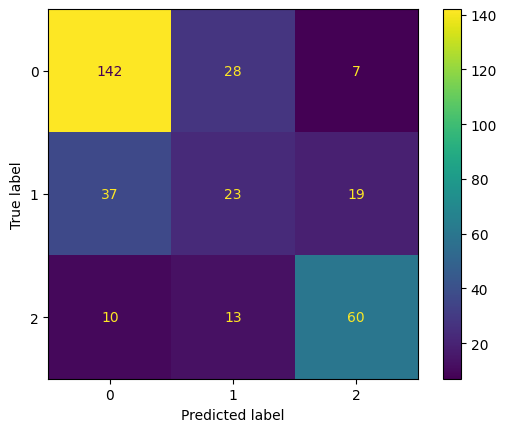

              precision    recall  f1-score   support

           0       0.75      0.80      0.78       177
           1       0.36      0.29      0.32        79
           2       0.70      0.72      0.71        83

    accuracy                           0.66       339
   macro avg       0.60      0.61      0.60       339
weighted avg       0.65      0.66      0.65       339



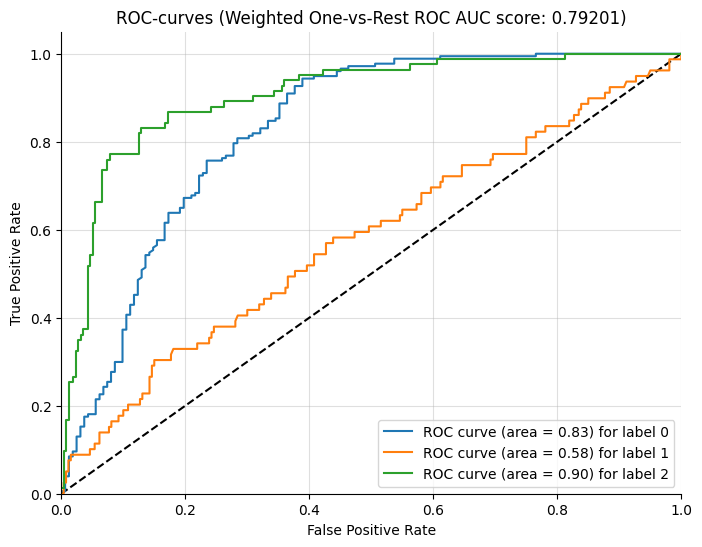

In [33]:
# Сохранение модели с наиболее удачными гиперпараметрами в переменную
best_model_1 = LogisticRegression(max_iter=884,
                                  solver='lbfgs',
                                  multi_class='ovr',
                                  class_weight='balanced',
                                  random_state=RANDOM_STATE)

# Создание итогового "пайплайна" с моделью
pipeline_best_model_1 = final_pipeline(best_model_1)

# Вывод результатов проверки работы модели
report_confmatrix_roc(pipeline_best_model_1, features_train, target_train, n_classes=3, cv=5)

**Замечание:**  Модель неплохо угадывает граничные классы (0 и 2). На классе 1 модель ошибается заметно чаще.

### Исследуем модель случайного леса `RandomForestClassifier`.

In [ ]:
# Функция для обучения и предсказания модели с перебором гиперпараметров 
def objective_2(trial):
    
    # Создание переменных для перебора гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 1, 1000)
    
    # Инициализация модели машинного обучения
    model = RandomForestClassifier(criterion=criterion,
                                   max_depth=max_depth,
                                   n_estimators=n_estimators,
                                   class_weight='balanced',
                                   random_state=RANDOM_STATE)
    
    # Создание итогового "пайплайна" с моделью
    pipeline = final_pipeline(model)
    
    # Проверка качества модели с помощью кросс-валидации                                 
    roc_auc = cross_val_score(pipeline,
                              features_train,
                              target_train,
                              cv=5,
                              scoring='roc_auc_ovr_weighted').mean()
    
    return roc_auc

# Обучение модели с перебором гиперпараметров с помощью модуля optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_2, n_trials=30)

# Поиск гиперпараметров лучшей модели
study.best_params

**Замечание:**   
Гиперпараметры лучшей модели: `criterion: gini`, `max_depth: 5`, `n_estimators: 974`.  
Результат лучшей модели: `roc_auc_ovr_weighted: 0.7926084991868639`. 

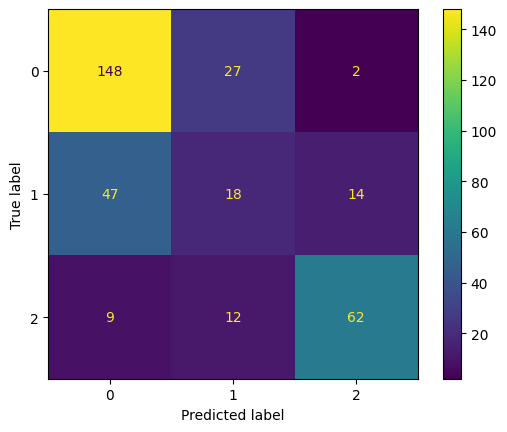

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       177
           1       0.32      0.23      0.26        79
           2       0.79      0.75      0.77        83

    accuracy                           0.67       339
   macro avg       0.61      0.60      0.60       339
weighted avg       0.65      0.67      0.66       339



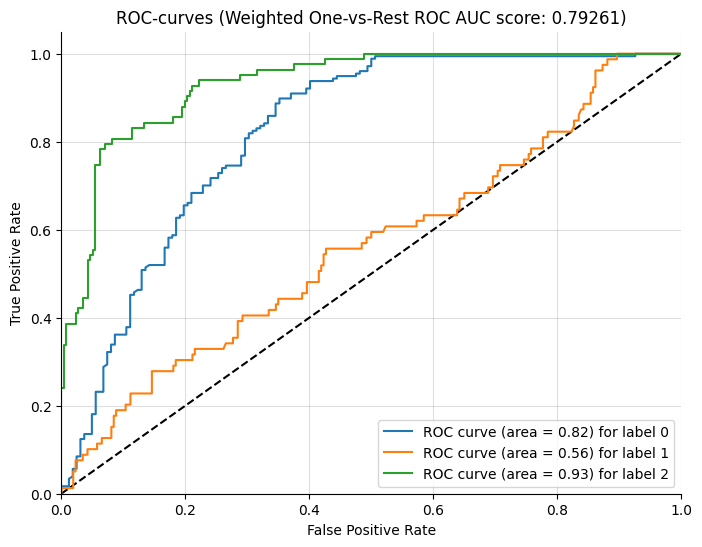

In [34]:
# Сохранение модели с наиболее удачными гиперпараметрами в переменную
best_model_2 = RandomForestClassifier(criterion='gini',
                                      max_depth=5,
                                      n_estimators=974,
                                      class_weight='balanced',
                                      random_state=RANDOM_STATE)

# Создание итогового "пайплайна" с моделью
pipeline_best_model_2 = final_pipeline(best_model_2)

# Вывод результатов проверки работы модели
report_confmatrix_roc(pipeline_best_model_2, features_train, target_train, n_classes=3, cv=5)

**Замечание:**  В общем случае данная модель немного обходит предыдущую по качеству. Однако она чаще ошибается на классе 1. В таком случае мы можем чаще пропускать потенциально опасное состояние для здоровья беременной женщины.

### Исследуем модель `LightGBMClassifier`.


In [ ]:
# Функция для обучения и предсказания модели с перебором гиперпараметров 
def objective_3(trial):
    
    # Создание переменных для перебора гиперпараметров
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3 )
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 1, 1000)
    
    # Инициализация модели машинного обучения
    model = LGBMClassifier(boosting_type=boosting_type,
                           learning_rate=learning_rate,
                           max_depth=max_depth,
                           n_estimators=n_estimators,
                           objective='multiclass',
                           class_weight='balanced',
                           verbose=-1,
                           random_state=RANDOM_STATE)
    
    # Создание итогового "пайплайна" с моделью
    pipeline = final_pipeline(model)
    
    # Проверка качества модели с помощью кросс-валидации                                 
    roc_auc = cross_val_score(pipeline,
                              features_train,
                              target_train,
                              cv=5,
                              scoring='roc_auc_ovr_weighted').mean()
    
    return roc_auc

# Обучение модели с перебором гиперпараметров с помощью модуля optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_3, n_trials=30)

# Поиск гиперпараметров лучшей модели
study.best_params

**Замечание:**   
Гиперпараметры лучшей модели:`boosting_type: dart`, `learning_rate: 0.016494109560633925`, `max_depth: 38`, `n_estimators: 769`.   
Результат лучшей модели: `roc_auc_ovr_weighted:  0.8050359346482076`. 

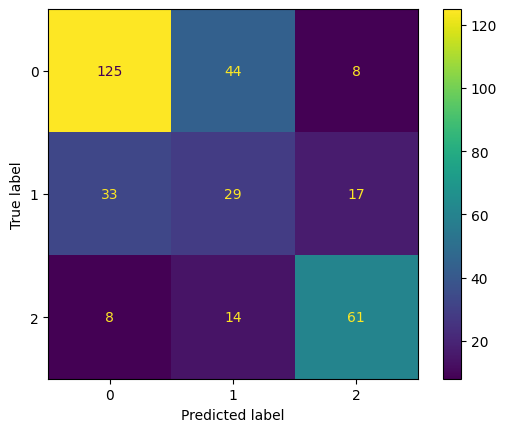

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       177
           1       0.33      0.37      0.35        79
           2       0.71      0.73      0.72        83

    accuracy                           0.63       339
   macro avg       0.60      0.60      0.60       339
weighted avg       0.64      0.63      0.64       339



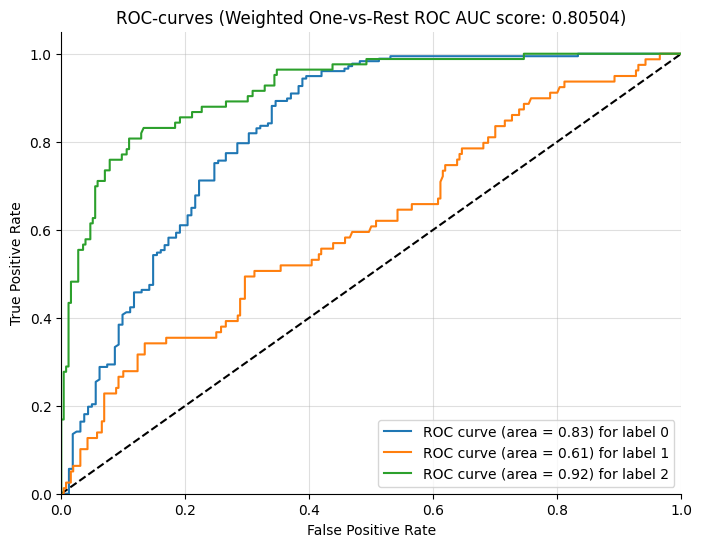

In [35]:
# Сохранение модели с наиболее удачными гиперпараметрами в переменную
best_model_3 = LGBMClassifier(boosting_type='dart',
                              learning_rate=0.016494109560633925,
                              max_depth=38,
                              n_estimators=769,
                              objective='multiclass',
                              class_weight='balanced',
                              verbose=-1,
                              random_state=RANDOM_STATE)

# Создание итогового "пайплайна" с моделью
pipeline_best_model_3 = final_pipeline(best_model_3)

# Вывод результатов проверки работы модели
report_confmatrix_roc(pipeline_best_model_3, features_train, target_train, n_classes=3, cv=5)

**Замечание:**  Модель градиентного бустинга ожидаемо обходит остальные по качеству, хотя и несильно. 

### Исследуем ансамблирование модели методом `VotingClassifier`.
Попробуем улучшить качество нашей последней модели `LGBMClassifier` объединив её в ансамбль с ранее исследуемыми (`LogisticRegression` и `RandomForestClassifier`). Собранная модель будет выполнять предсказания на основе головования в соотношении 1:1:3 (где 3 - самая важная модель градиентного бустинга).

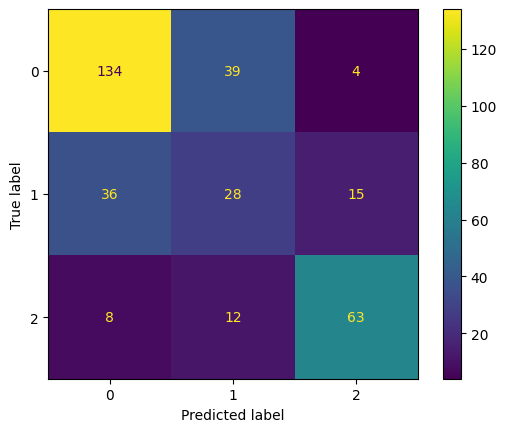

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       177
           1       0.35      0.35      0.35        79
           2       0.77      0.76      0.76        83

    accuracy                           0.66       339
   macro avg       0.63      0.62      0.62       339
weighted avg       0.66      0.66      0.66       339



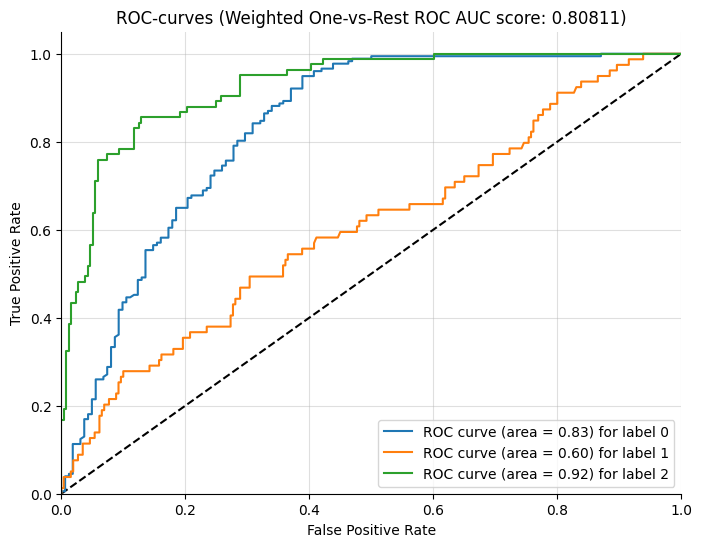

In [36]:
# Инициализация модели голосования на основе трёх лучших моделей
vote_model = VotingClassifier(estimators=[('best_model_1', best_model_1),
                                          ('best_model_2', best_model_2),
                                          ('best_model_3', best_model_3)],
                              weights=[1, 1, 3],
                              voting='soft')

# Создание итогового "пайплайна" с моделью
pipeline_best_model_vote = final_pipeline(vote_model)

# Вывод результатов проверки работы модели
report_confmatrix_roc(pipeline_best_model_vote, features_train, target_train, n_classes=3, cv=5)

**Замечание:**  Нам удалось ещё немного улучшить точность предсказаний. 

## Проверка "лучшей" модели

Лучшее качество показала модель `VotingClassifier` - ансамбль из моделей `LogisticRegression`, `RandomForestClassifier` и `LGBMClassifier` (в соотношении по важности -  1:1:3) с подобранными по отдельности гиперпараметрами.

В дальнейшем можно сначала собрать модели в ансамбль и перебирать все гиперпараметры вместе. Это может улучшить качество прогнозов нашей модели.

### Проверим качество итоговой модели на тестовой выборке.
Обучим нашу модель на всей тренировочной выборке сразу.

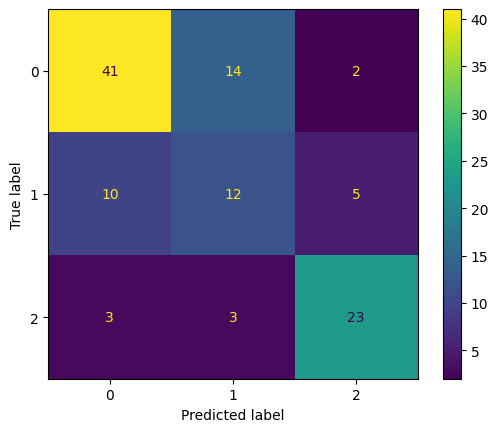

              precision    recall  f1-score   support

           0       0.76      0.72      0.74        57
           1       0.41      0.44      0.43        27
           2       0.77      0.79      0.78        29

    accuracy                           0.67       113
   macro avg       0.65      0.65      0.65       113
weighted avg       0.68      0.67      0.68       113



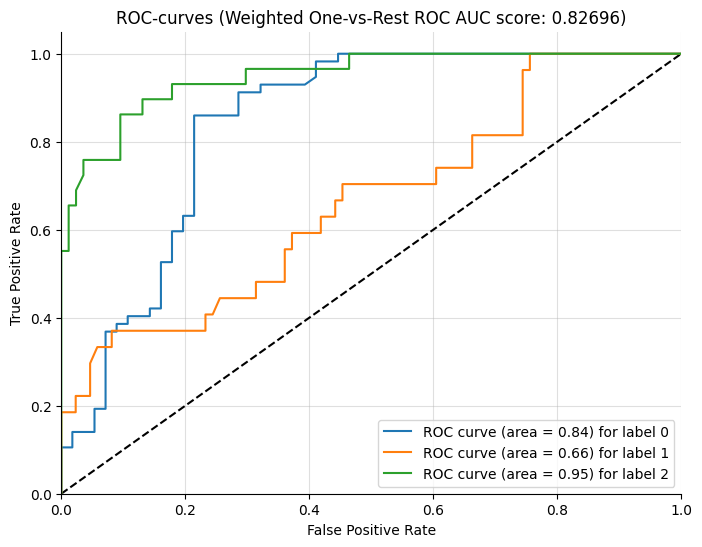

In [37]:
# Определение модели для тестирования
test_model = vote_model

# Создание итогового "пайплайна" с моделью
pipeline_test_model = final_pipeline(test_model)

# Обучение модели на всей тренировочной выборке сразу
pipeline_test_model.fit(features_train, target_train)

# Выполнение предсказания на тестовой выборке
predict_test = pipeline_test_model.predict(features_test)

# Рассчёт вероятностей классов на тестовой выборке
probabilities_test = pipeline_test_model.predict_proba(features_test)

# Рассчёт метрики качества модели
roc_auc_weighted_test = round(roc_auc_score(target_test,
                                            probabilities_test,
                                            average='weighted',
                                            multi_class='ovr'), 5)

# Построение матрицы ошибок
cm = confusion_matrix(target_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

# Вывод значений метрик классификации
print(classification_report(target_test, predict_test))

# Создание пустых словарей
fpr = dict()
tpr = dict()
roc_auc = dict()
    
# Кодирование целевого признака (3 класса: 0, 1 и 2) с помощью OHE как будто он категориальный
target_dummies = pd.get_dummies(target_test, drop_first=False).values
    
# Получение значений для построения ROC кривых (для 3 классов)
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_dummies[:, i], probabilities_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
        
# Построение ROC кривой для каждого класса
fig, ax = plt.subplots(figsize=(8, 6))    
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC-curves (Weighted One-vs-Rest ROC AUC score: {roc_auc_weighted_test})')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

**Замечание:** Модель показала результаты лучшие чем на тренировочной выборке. Это объясняется крайне малым количеством исходных данных. Напомним, что на этапе прдобработки после удаления дубликатов у нас осталось всего 452 строки. 



**Для информации:**   
Если обучить нашу модель первоначальном датасете без удаления дубликатов и добавления новых признаков, качество предсказаний будет заметно выше. Возможно, это происходит из-за существенного увеличение размера обучающего набора (более чем в 2 раза) и уменьшения дисперсии (например, деревья случайного леса будут обучаться на похожих данных и усреднять свои предсказания). 

Однако, дубликаты могут привести к переобучению модели. Например, для градиентного бустинга, каждая модель в ансамбле строится на основе ошибок предыдущих моделей, дубликаты могут привести к усилению ошибок. То есть модель может учиться на этих повторяющихся примерах вместо того, чтобы обобщать информацию и делать предсказания на основе уникальных образцов.

### Построим кривые обучения модели.
График будем строить на основе обучающей выборки.

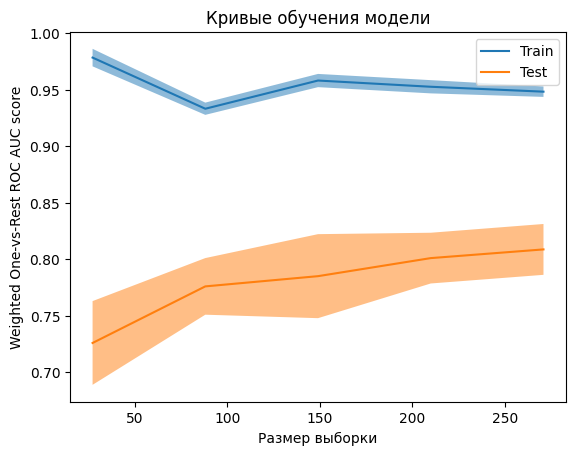

In [38]:
# Рассчёт параметров для построения кривой обучения
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline_test_model,
                                                        X=features_train,
                                                        y=target_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        cv=5,
                                                        scoring='roc_auc_ovr_weighted',
                                                        random_state=RANDOM_STATE)

# Визуализация кривой обучения
display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=train_scores,
                               test_scores=test_scores)
fig, ax = plt.subplots()
display.plot(ax=ax, score_type='both')
ax.set_xlabel('Размер выборки')
ax.set_ylabel('Weighted One-vs-Rest ROC AUC score')
ax.set_title('Кривые обучения модели')
fig.show();

**Замечание:** С увеличением количества данных ключевая метрика на тесте продолжает увеличиваться. Следовательно у нашей итоговой модели ещё есть потенциал к увеличению точности предсказаний. Этот наблюдение подтверждает, вполне очевидное, предположение о малом количестве данных, сделанное на предыдущим этапе.

### Проверим модель на адекватность.
Для проверки на адекватность будем использовать наивную модель, которая будет предсказывать классы, на основе стратификации. 
Это означает, что вероятности принадлежности к каждому классу будут пропорциональны их доле в обучающей выборке.   
Таким образом мы можем сравнить, например, `Accuracy`.  
Для целевой метрики `AUC-ROC` смысла в этой проверке нет. Значение этой метрики для наивной модели будет равно около 0,5.  
На графиках "ROC-кривая" значение `AUC-ROC=0.5` отображается прямой пунктирной линией.

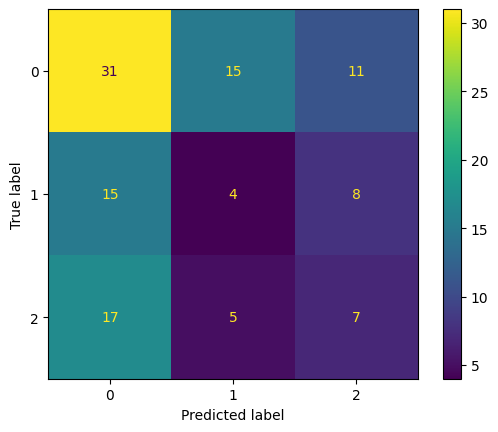

              precision    recall  f1-score   support

           0       0.49      0.54      0.52        57
           1       0.17      0.15      0.16        27
           2       0.27      0.24      0.25        29

    accuracy                           0.37       113
   macro avg       0.31      0.31      0.31       113
weighted avg       0.36      0.37      0.36       113



In [39]:
# Инициализация наивной моделиь с заданными гиперпараметрами
model_dummy_stratified = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

# Обучение наивной модели на тренировочных данных
model_dummy_stratified.fit(features_train, target_train)

# Получение значения целевой переменной на тестовой выборке
dummy_predictions_test = model_dummy_stratified.predict(features_test)

# Построение матрицы ошибок
cm = confusion_matrix(target_test, dummy_predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

# Вывод значений метрик классификации
print(classification_report(target_test, dummy_predictions_test))

**Замечание:**  Наивная модель значительно уступает в качестве построенной нами модели. Проверка на адекватность пройдена. 

### Оценим важность признаков для работы модели.

Для данной модели важность признаков будем оценивать методами `permutation_importance`.   

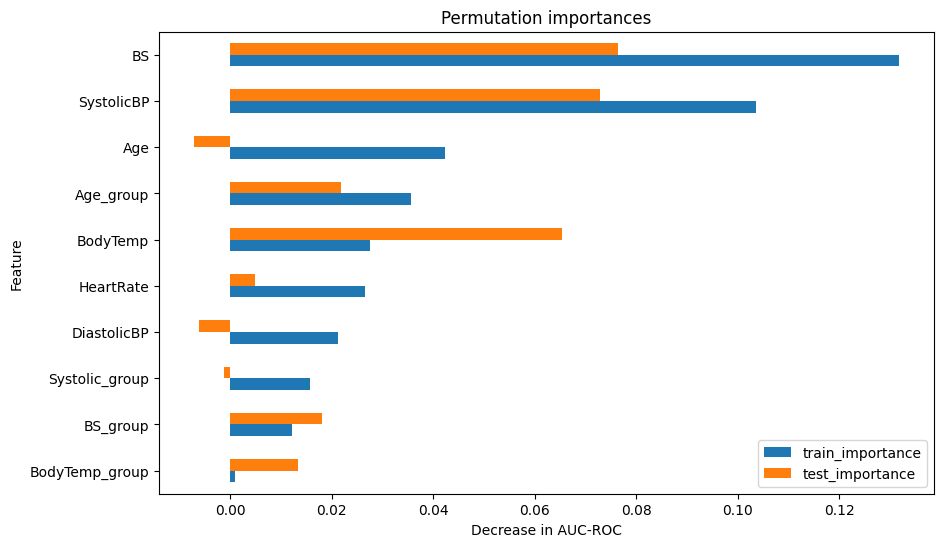

In [40]:
# Получение значений важности признаков для модели машинного обучения на тренировочных данных
train_results = permutation_importance(pipeline_test_model,
                                       features_train,
                                       target_train,
                                       scoring='roc_auc_ovr_weighted',
                                       n_repeats=5,
                                       random_state=RANDOM_STATE)

# Получение значений важности признаков для модели машинного обучения на тестовых данных
test_results = permutation_importance(pipeline_test_model,
                                      features_test,
                                      target_test,
                                      scoring='roc_auc_ovr_weighted',
                                      n_repeats=5,
                                      random_state=RANDOM_STATE)

# Создание таблицы со значениями коэффициентов и названиями признаков
feature_importance = pd.DataFrame({'Feature': features_train.columns,
                                   'train_importance': train_results.importances_mean,
                                   'test_importance': test_results.importances_mean})

# Сортировка значений по убыванию
feature_importance = feature_importance.sort_values('train_importance', ascending=True)

# Построение столбчатого горизонтального графика
feature_importance.plot(kind='barh', x='Feature', figsize=(10, 6))
plt.xlabel('Decrease in AUC-ROC');
plt.title('Permutation importances');

**Замечание:**  Мы видим, что на тестовой выборке важность признаков `permutation_importance` изменяется. 
Например, снижается влияние признаков `Age` и `DiastolicBP` на ключевую метрику `AUC-ROC`. Эти признаки даже стали отрицательно влиять на ключевую метрику. 
А признаки `BodyTemp`и `BodyTemp_group` стали влиять на неё заметно больше.   

Отрицательные значения для `permutation_importance` говорят о том, что в этих случаях предсказания на основе перетасованных (или зашумленных) данных оказывались более точными, чем реальные данные. Это происходит, когда признак не был важен (ожидалось значение, близкое к 0), но случайность привела к тому, что прогнозы по перетасованным данным оказались более точными. Такое встречается с небольшими наборами данных, подобными нашему, так как в них больше возможностей для случайности.

От некоторых признаков, в принципе, можно избавиться. Но для этого нужно проверить работу модели на большем количестве данных. На основе имеющейся выборки такие предположения делать не стоит.

## Итоговый вывод

В данном проекте мы провели, анализ факторов риска, которые могут вызвать осложнения состояния здоровья у беременных женщин и  построили модель машинного обучения прогнозирующую "риски здоровья" на основе имеющихся наблюдений (о состоянии их здоровья).

**Этапы выполнения проекта:**   

    
**Изучение данных.**   
Здесь мы установили и импортировали необходимые для работы библиотеки, загрузили и изучили данные. 
      
**Предобработка данных.**   
На данном этапе мы удалили дубликаты и обработали аномальные значения. Для дальнейшей работы мы сгенерировали новые признаки.

**Исследовательский анализ данных.**   
На этой стадии проекта мы рассчитали корреляцию признаков, изучили их распределения и искали зависимости между ними.
    
**Подготовка данных.**   
Тут мы выделили необходимые для работы моделей признаки (`features` и `target`). После этого разделили данные на выборки (соотношение 75:25), составили `pipline` для кодирование категориальных признаков и масштабирования числовых. 
    
**Построение и анализ моделей.**   
Были рассмотрены следующие типы моделей: `LogisticRegression`, `RandomForestClassifier`, `LightGBMClassifier`. Лучшее качество показал ансамбль на основе этих моделей собранный с помощью метода `VotingClassifier`.
    
**Проверка "лучшей" модели.**   
На последнем этапе мы проверили "лучшую" модель на тестовой выборке, построили кривые обучения, а также провели проверку на адекватность и оценили важность признаков.
    


**В итоге:**    

Лучший результат показал ансамбль моделей:    
```
VotingClassifier(estimators=[LogisticRegression(),   
                             RandomForestClassifier(),   
                             LGBMClassifier()],   
                 weights=[1, 1, 3],   
                 voting='soft')                                   
```                              
Гиперпараметры моделей:    
```
LogisticRegression(max_iter=884,   
                   solver='lbfgs',   
                   multi_class='ovr',   
                   class_weight='balanced',   
                   random_state=23)   
RandomForestClassifier(criterion='gini',   
                       max_depth=5,   
                       n_estimators=974,   
                       class_weight='balanced',   
                       random_state=23)   
LGBMClassifier(boosting_type='dart',   
               learning_rate=0.016494109560633925,   
               max_depth=38,   
               n_estimators=769,   
               objective='multiclass',   
               class_weight='balanced',   
               random_state=23)                                     
```                                  
**Качество нашей модели на тестовой выборке (`roc_auc_ovr_weighted = 0,82696`).**                                  